In [82]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive'
/content/drive/MyDrive


In [83]:
import sys
sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks')

In [ ]:
!pip install fuzzywuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [84]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from knn_recommender import Recommender
import sqlite3
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.9/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


# **1. Import Data from log files and basic exploration**
**Dataset:**

We use the "Taste profile subset" dataset that is auxillary to the popular million songs dataset available at: [The Million Song Dataset](http://millionsongdataset.com/) It is a freely-available collection of audio features and metadata for a million contemporary popular music tracks. The purpose of choosing such a large dataset is to build and test recommender systems at scale. Although the entire dataset is of 280 GB, we deal only with 3 GB of available sample data which still exhibits characteristics of a large dataset while being moderately computationally intensive to model.

Since, the overall dataset has more than a million unique users and records about 384,000 songs, we would first read a subset (10000 records) of data

In [ ]:
dfsongs = pd.read_csv("train_triplets.txt", sep="\t", nrows=10000, names=['user', 'song', 'play_count'], header=None)


Let us inspect some of the imported records and other characteristics of data before we proceed further

In [ ]:
dfsongs.head(5)


,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


# Power-Law in real world systems
In most real world web applications, we see that only a few number of users consume a majority of the services while most other users use the services very rarely. In such a scenario, we need to take into account only those frequent song listeners to build a significant recommender.

# 2. Summarizing records by users and songs:
We first summarize the records by users and then by songs.

**2.1 Users - play count summary**

In [ ]:
from collections import defaultdict
usersDict = defaultdict(int)
with open("train_triplets.txt", "r") as songFile:
    for record in songFile:
        #Fetch user id as the first item from a tab delimited line of record
        user = record.split("\t")[0]
        #Fetch song play count as the last item from a tab delimited line of record
        play_count = int(record.split("\t")[2])
        #Update song play count for a user
        usersDict[user] += play_count
        
userPlayCountList = [{'user': u, 'play_count': p} for u,p in usersDict.items()]
dfSongsPlayCount = pd.DataFrame(userPlayCountList)
#Arrange the user songs played records in descending order to facilitate further analysis
dfSongsPlayCount = dfSongsPlayCount.sort_values(by = 'play_count', ascending = False)
dfSongsPlayCount.to_csv("songs_play_count.csv", index=None)

In [ ]:
dfSongsPlayCount

,user,play_count
669980,093cb74eb3c517c5179ae24caf0ebec51b24d2a2,13132
402687,119b7c88d58d0c6eb051365c103da5caf817bea6,9884
964856,3fa44653315697f42410a30cb766a4eb102080bb,8210
462404,a2679496cd0af9779a92a13ff7c6af5c81ea8c7b,7015
991089,d7d2d888ae04d16e994d6964214a1de81392ee04,6494
...,...,...
465556,ed0e17348ea44b302b87078f0620343ba9b754b5,10
967950,b983b36e486f64fb87c2b055233952e2dae187fa,10
1004805,52728cecec25586097e2f4b8b7397053fed5ba90,10
754750,5f18f970c6a597d60a19d26c131dfc04e80a1fc4,10


In [ ]:
totalPlayCount = sum(dfSongsPlayCount.play_count)
(float(dfSongsPlayCount.head(n=75000).play_count.sum())/totalPlayCount)*100

34.50197011841117

The top 75000 users (top 7.5%) have 35% of the total play count of all songs

In [ ]:
dfUserSubset = dfSongsPlayCount.head(n=75000)

Here, we are taking only the subset of top 75000 users for our model

In [ ]:
dfUserSubset

,user,play_count
669980,093cb74eb3c517c5179ae24caf0ebec51b24d2a2,13132
402687,119b7c88d58d0c6eb051365c103da5caf817bea6,9884
964856,3fa44653315697f42410a30cb766a4eb102080bb,8210
462404,a2679496cd0af9779a92a13ff7c6af5c81ea8c7b,7015
991089,d7d2d888ae04d16e994d6964214a1de81392ee04,6494
...,...,...
685013,79f701b54a273c1ecad440ba2141baf9e11f77de,385
237573,92115abcb22c891eb3bc8304a58ccf79a3f31ec0,385
371254,8498a13fbb56cbaac9e2dfb5b4bd25d775dbbfd3,385
292201,89cc49fc0523ca720f6a261f0d9bbbedade3a950,385


**2.2 Songs - play count summary:**

In [ ]:
songsDict = defaultdict(int)
with open("train_triplets.txt", "r") as songFile:
    for record in songFile:
        #Fetch song id as the first item from a tab delimited line of record
        song = record.split("\t")[1]
        #Fetch song play count as the last item from a tab delimited line of record
        play_count = int(record.split("\t")[2])
        #Update song play count for a song
        songsDict[song] += play_count
        
songPlayCountList = [{'song': s, 'play_count': p} for s,p in songsDict.items()]
dfSongsPlaySummary = pd.DataFrame(songPlayCountList)
#Arrange the user songs played records in descending order to facilitate further analysis
dfSongsPlaySummary = dfSongsPlaySummary.sort_values(by = 'play_count', ascending = False)
dfSongsPlaySummary.to_csv("songs_summary.csv", index=None)

In [ ]:
dfSongsPlaySummary

,song,play_count
202,SOBONKR12A58A7A7E0,726885
199,SOAUWYT12A81C206F1,648239
218,SOSXLTC12AF72A7F54,527893
22,SOFRQTD12A81C233C0,425463
206,SOEGIYH12A6D4FC0E3,389880
...,...,...
326175,SOXZARS12AB01851EE,1
326176,SOCCQEA12AB017E7CF,1
272569,SOGNHOL12A8C13C379,1
361600,SOPXELI12A8C13FAB0,1


In [ ]:
(float(dfSongsPlaySummary.head(n=10000).play_count.sum())/totalPlayCount)*100

59.09176046078892

Observation:

Top 10,000 songs(top 2.5%) are listened on almost 60% occasions

Now taking those top 10,000 songs for our model:

In [ ]:
dfSongPlayCountSubset = dfSongsPlaySummary.head(n=10000)
dfSongPlayCountSubset

,song,play_count
202,SOBONKR12A58A7A7E0,726885
199,SOAUWYT12A81C206F1,648239
218,SOSXLTC12AF72A7F54,527893
22,SOFRQTD12A81C233C0,425463
206,SOEGIYH12A6D4FC0E3,389880
...,...,...
54785,SOUSVDG12AB018B099,2461
21694,SOWKZYZ12A8C140C20,2461
1339,SORXMNW12A58A7D198,2460
24088,SOHQYKY12AB017A589,2460


In [ ]:
dfAllSongs = pd.read_csv("train_triplets.txt", sep="\t", names=['user', 'song', 'play_count'], header=None)
#Filter records for top 40% users using the users subset found earlier
dfSongsTopUsers = dfAllSongs[dfAllSongs.user.isin(list(dfUserSubset.user))]
dfSongsTopSongs = dfSongsTopUsers[dfSongsTopUsers.song.isin(list(dfSongPlayCountSubset.song))]

In [ ]:
dfSongsTopSongs

,user,song,play_count
560,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAFTRR12AF72A8D4D,1
561,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAIILB12A58A776F7,3
563,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAJJDS12A8C13A3FB,1
565,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAKDHD12A6310F1AE,1
566,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAMDXO12A8C131E2F,2
...,...,...,...
48373460,8305c896f42308824da7d4386f4b9ee584281412,SOZDGEW12A8C13E748,4
48373461,8305c896f42308824da7d4386f4b9ee584281412,SOZEETS12AC9071BD3,1
48373462,8305c896f42308824da7d4386f4b9ee584281412,SOZKNSB12A8C140F11,1
48373463,8305c896f42308824da7d4386f4b9ee584281412,SOZVCRW12A67ADA0B7,2


In [ ]:
#Save the top 30 songs dataset to a file
dfSongsTopSongs.to_csv("top_Songs_Subset.csv", index=False)
#Find the number of records in this subset
dfSongsTopSongs.shape

(6046043, 3)

In [ ]:
del dfAllSongs
del dfSongsTopUsers

# **3. Enhance Dataset with Song Track Details**
Though we have obtained a subset of popular songs, it lacks song titles, artist names and other such details. These details can be retrived from a available supporting dataset of metadata in SQLite format at [Million Songs Metdata](http://millionsongdataset.com/)

In [ ]:
conn = sqlite3.connect('track_metadata.db')
cur = conn.cursor()
#Find the name of tables in the database
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
cur.fetchall()

[('songs',)]

In [ ]:
#Retrieve details of song tracks from the metadata file
dfTrackMetadata = pd.read_sql(con=conn, sql='select * from songs')
dfTrackMetadata_sub = dfTrackMetadata[dfTrackMetadata.song_id.isin(list(dfSongPlayCountSubset.song))]

In [ ]:
dfTrackMetadata_sub

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
145,TRMMGDP128F933E59A,I Say A Little Prayer,SOGWEOB12AB018A4D0,The Legendary Hi Records Albums_ Volume 3: Ful...,ARNNRN31187B9AE7B7,fb7272ba-f130-4f0a-934d-6eeea4c18c9a,Al Green,133.58975,0.779490,0.599210,1978,5211723,-1,11898
245,TRMMCDR128F423AB03,Anyone Else But You,SOSZNRJ12A8AE46E38,Juno - Music From The Motion Picture,AR62GN71187B9AAD0C,70fada2a-5b8c-4988-a2d7-79576d7f6daf,Michael Cera & Ellen Page,116.71465,0.540441,0.464981,2007,2028040,-1,0
412,TRMMFSL128F4234583,Drunk and Hot Girls,SOGKGLB12A81C22AFA,Graduation,ARRH63Y1187FB47783,164f0d73-1234-4e2c-8743-d77bf2191051,Kanye West / Mos Def,313.28608,0.877214,1.082503,2007,1356708,-1,0
464,TRMMQSP128F1486267,Until The Day I Die (Album Version),SOWZDNH12A6D4F7237,Page Avenue,ARF6ZTO1187FB3684F,e2c3c508-f0ab-49af-92c9-a81d66d67405,Story Of The Year,235.78077,0.806763,0.580095,2003,471119,-1,0
484,TRMMQOL128F9340687,Rewind (Demo),SOQBGZD12AB0184341,Riot!,AR4OU721187FB4549D,728ea90d-279b-4201-a8c4-597830883150,Paramore,226.95138,0.951488,0.658925,0,5669453,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999555,TRYYJQY128F9320622,Island,SOINBEP12AB017FEE1,Rules,AR5NQPT1187FB45A43,f83781c8-64f9-4657-85bd-51f74d195cfd,The Whitest Boy Alive,423.49669,0.736721,0.502305,2009,4580757,-1,0
999643,TRYYVPJ128F427E2ED,Suggestions,SOAPUFN12AB017FF03,System Of A Down (Bonus Pack),AR9C8IE1187B9ACC99,cc0b7089-c08d-4c10-b6b0-873582c17fd6,System of a Down,163.94404,0.909958,0.609262,1998,3272607,-1,0
999730,TRYYDLF128F423BB17,House By the Sea (Album),SOETNKM12A8AE47EEA,The Shepherd's Dog,AR4XX0N1187FB45C21,c3f28da8-662d-4f09-bdc7-3084bf685930,Iron And Wine,261.82485,0.720967,0.535342,2007,1401542,-1,0
999740,TRYYOWT128F42B6558,Ruled By Secrecy,SODNVTM12A6D4FA448,Absolution,ARR3ONV1187B9A2F59,fd857293-5ab8-40de-b29e-55a69d4e4d0f,Muse,292.28363,0.929030,0.750427,0,3505486,-1,0


# **4. Preprocessing the data**
Now that we have all the relevant information, we need to aggregate the song details and user Ids and remove the unwanted columns from the final cleaned table

In [ ]:
del(dfTrackMetadata_sub['track_id'])
del(dfTrackMetadata_sub['artist_mbid'])
#Drop duplicate songs ids, as we are concerned with only unique songs
dfTrackMetadata_sub.drop_duplicates(['song_id'], inplace=True)
#Join the earlier obtained top popular songs dataset and this metadata dataframe on song id
dfPopularSongMetaDataMerged = pd.merge(dfSongsTopSongs, dfTrackMetadata_sub, how="left", 
                                      left_on="song", right_on = "song_id")
#Keep only relevant columns
dfPopularSongMetaDataMerged = dfPopularSongMetaDataMerged[['user', 'song', 'title',
                                                           'play_count', 'release', 'artist_name', 'year']]
dfPopularSongMetaDataMerged.head(3)

<ipython-input-21-1af59e3f7e85>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfTrackMetadata_sub.drop_duplicates(['song_id'], inplace=True)


,user,song,title,play_count,release,artist_name,year
0,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAFTRR12AF72A8D4D,Harder Better Faster Stronger,1,Discovery,Daft Punk,2007
1,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAIILB12A58A776F7,Phantom Part 1.5 (Album Version),3,A Cross The Universe,Justice,0
2,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAJJDS12A8C13A3FB,I Got Mine,1,Attack & Release,The Black Keys,2008


In [ ]:
dfPopularSongMetaDataMerged

,user,song,title,play_count,release,artist_name,year
0,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAFTRR12AF72A8D4D,Harder Better Faster Stronger,1,Discovery,Daft Punk,2007
1,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAIILB12A58A776F7,Phantom Part 1.5 (Album Version),3,A Cross The Universe,Justice,0
2,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAJJDS12A8C13A3FB,I Got Mine,1,Attack & Release,The Black Keys,2008
3,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAKDHD12A6310F1AE,Face To Face (Cosmo VItelli Remix),1,Daft Club,Daft Punk,2003
4,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAMDXO12A8C131E2F,Pogo,2,Idealism,Digitalism,2007
...,...,...,...,...,...,...,...
6046038,8305c896f42308824da7d4386f4b9ee584281412,SOZDGEW12A8C13E748,One,4,...And Justice For All,Metallica,1988
6046039,8305c896f42308824da7d4386f4b9ee584281412,SOZEETS12AC9071BD3,Favorite Girl,1,My World,Justin Bieber,2009
6046040,8305c896f42308824da7d4386f4b9ee584281412,SOZKNSB12A8C140F11,Replay,1,Massive R&B Spring 2010,Iyaz,2009
6046041,8305c896f42308824da7d4386f4b9ee584281412,SOZVCRW12A67ADA0B7,When You Were Young,2,When You Were Young,The Killers,2006


# **Exploring the data**
As usual, any data science or machine learning project starts with an exploratory data analysis (EDA). The aim of EDA is to understand and get insights on our data.

We'll first inspect the first rows of our DataFrame.

Now, Checking if there is any row which doesn't have the metadata for the song id

In [ ]:
dfPopularSongMetaDataMerged[dfPopularSongMetaDataMerged['title'].isnull()]

,user,song,title,play_count,release,artist_name,year


# **Most popular songs**
How do we determine which are the most popular songs? For this task, we'll count how many times each song appears. Note that while we are using listen_count, we only care about the number of rows, we don't consider the number present in that row. This number represents how many times one user listen to the same song.

In [ ]:
#count how many rows we have by song, we show only the ten more popular songs 
ten_pop_songs = dfPopularSongMetaDataMerged.groupby('title')['play_count'].count().reset_index().sort_values(['play_count', 'title'], ascending = [0,1])
ten_pop_songs['percentage']  = round(ten_pop_songs['play_count'].div(ten_pop_songs['play_count'].sum())*100, 2)

In [ ]:
ten_pop_songs = ten_pop_songs[:10]
ten_pop_songs

,title,play_count,percentage
6861,Sehr kosmisch,14395,0.24
1954,Dog Days Are Over (Radio Edit),13811,0.23
9502,You're The One,12445,0.21
6846,Secrets,11840,0.20
6523,Revelry,11625,0.19
8732,Undo,11214,0.19
2599,Fireflies,10318,0.17
8782,Use Somebody,10234,0.17
3335,Hey_ Soul Sister,10226,0.17
3447,Horn Concerto No. 4 in E flat K495: II. Romanc...,9552,0.16


In [ ]:
labels = ten_pop_songs['title'].tolist()
counts = ten_pop_songs['play_count'].tolist()

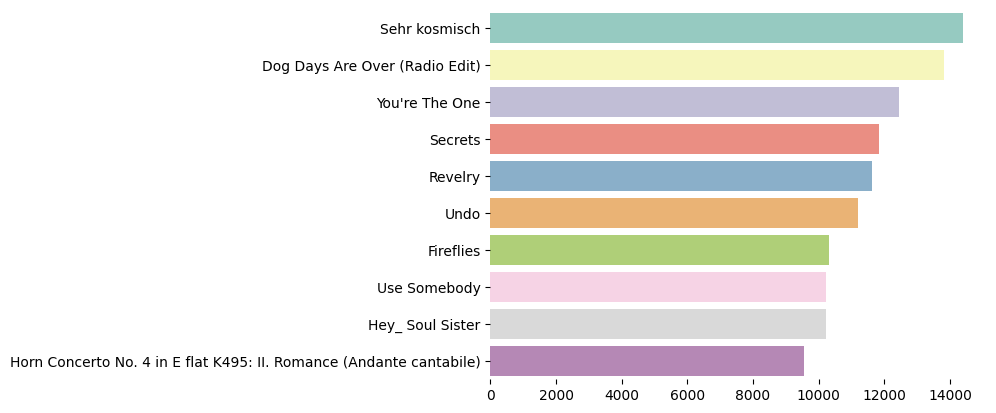

In [ ]:
plt.figure()
sns.barplot(x=counts, y=labels, palette='Set3')
sns.despine(left=True, bottom=True)

# **Most popular artist**
For the next task, we'll count how many times each artist appears. Again, we'll count how many times the same artist appears.

In [ ]:
#count how many rows we have by artist name, we show only the ten more popular artist 
ten_pop_artists  = dfPopularSongMetaDataMerged.groupby(['artist_name'])['play_count'].count().reset_index().sort_values(['play_count', 'artist_name'], 
                                                                                                ascending = [0,1])

In [ ]:
ten_pop_artists = ten_pop_artists[:10]
ten_pop_artists

,artist_name,play_count
780,Coldplay,98997
3406,The Black Keys,76506
3523,The Killers,60635
1649,Jack Johnson,59011
1976,Kings Of Leon,55305
2839,Radiohead,50457
1325,Florence + The Machine,48213
2482,Muse,47295
882,Daft Punk,46308
2112,Linkin Park,35562


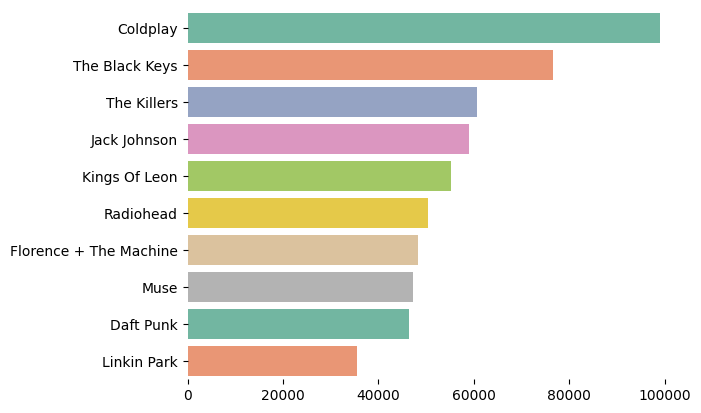

In [ ]:
plt.figure()
labels = ten_pop_artists['artist_name'].tolist()
counts = ten_pop_artists['play_count'].tolist()
sns.barplot(x=counts, y=labels, palette='Set2')
sns.despine(left=True, bottom=True)

# **Listen count by user**
We can also get some other information from the feature listen_count. We will answer the folloging questions:

In [ ]:
listen_counts = pd.DataFrame(dfPopularSongMetaDataMerged.groupby('play_count').size(), columns=['count'])

In [ ]:
print(f"The maximum time the same user listened to the same songs was: {listen_counts.reset_index(drop=False)['play_count'].iloc[-1]}")

The maximum time the same user listened to the same songs was: 9667


In [ ]:
print(f"On average, a user listen to the same song {dfPopularSongMetaDataMerged['play_count'].mean()} times")

On average, a user listen to the same song 4.561375762626895 times


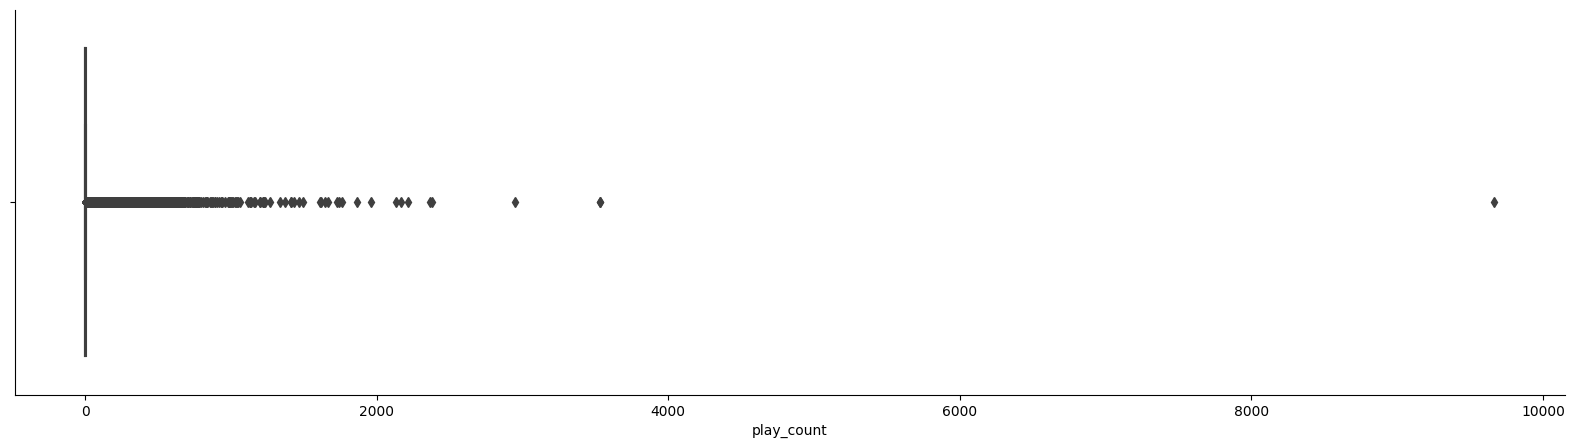

In [ ]:
plt.figure(figsize=(20, 5))
sns.boxplot(x='play_count', data=dfPopularSongMetaDataMerged)
sns.despine()

In [ ]:
listen_counts_temp = listen_counts[listen_counts['count'] > 200].reset_index(drop=False)

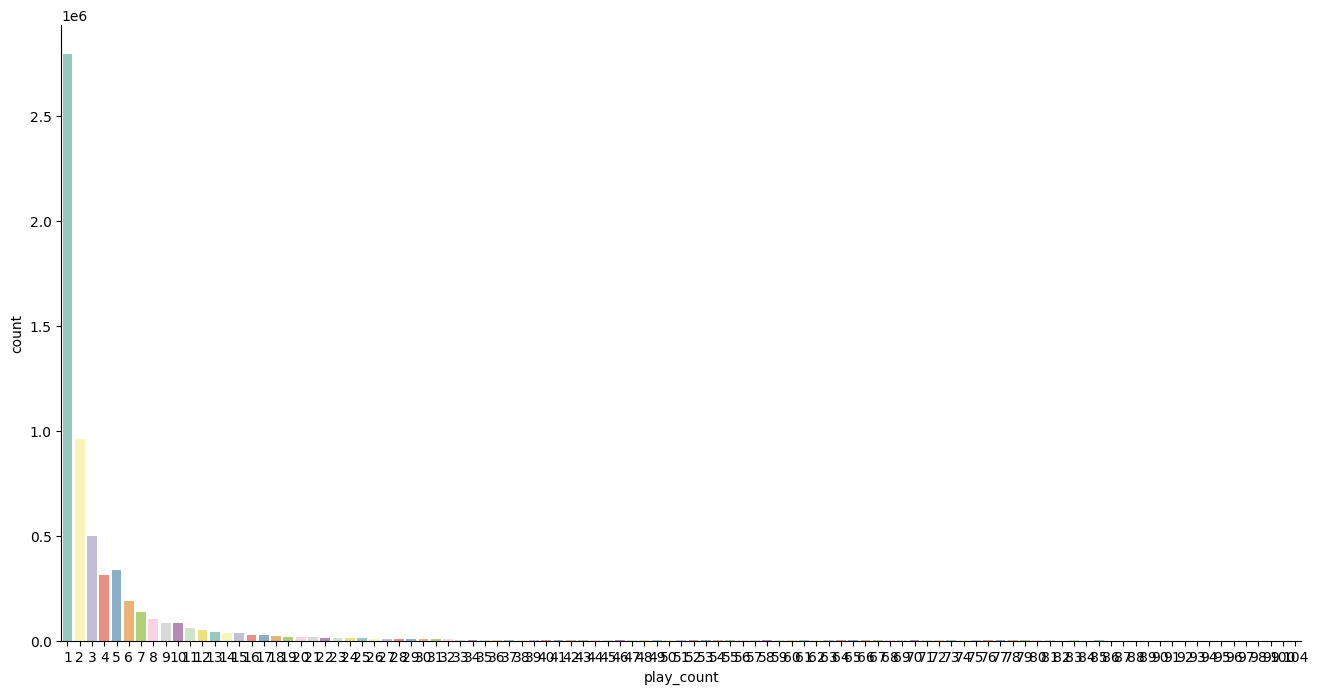

In [ ]:
plt.figure(figsize=(16, 8))
sns.barplot(x='play_count', y='count', palette='Set3', data=listen_counts_temp)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [ ]:
song_user = dfPopularSongMetaDataMerged.groupby('user')['song'].count()

<ipython-input-45-495547ecb817>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(song_user.values, color='orange')


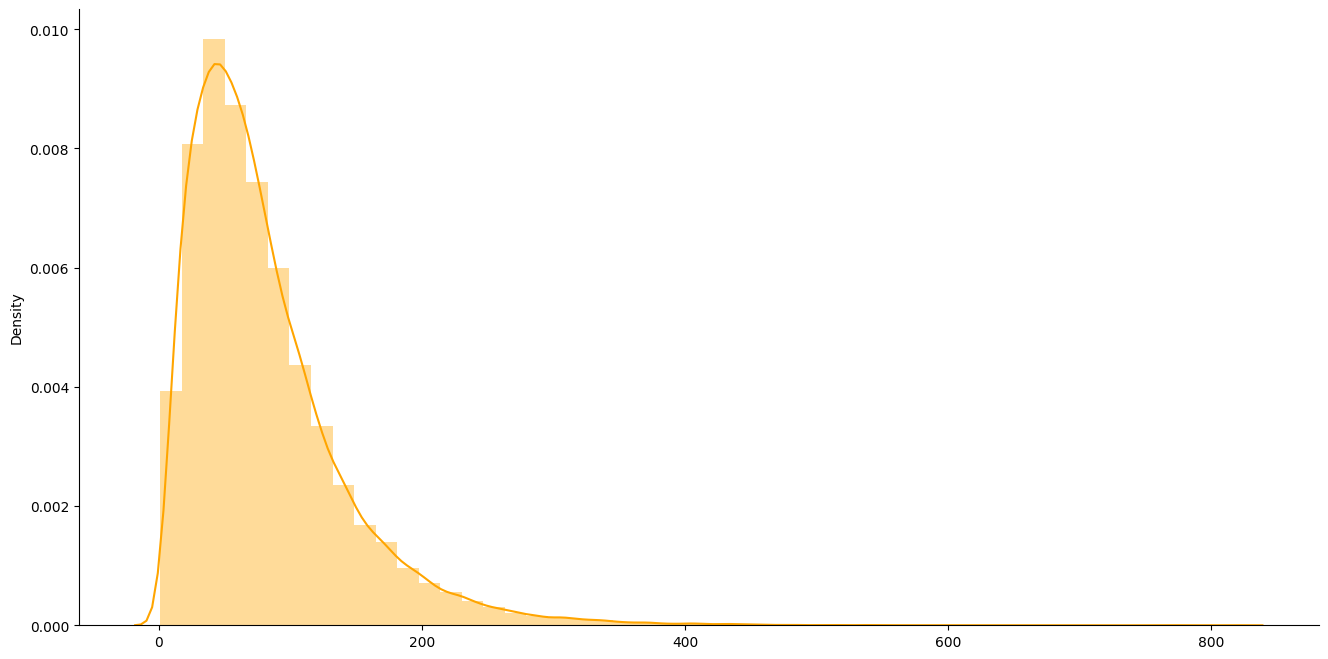

In [ ]:
plt.figure(figsize=(16, 8))
sns.distplot(song_user.values, color='orange')
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.show();

In [ ]:
print(f"A user listens to an average of {np.mean(song_user)} songs")

A user listens to an average of 80.63325864874237 songs


In [ ]:
print(f"A user listens to an average of {np.median(song_user)} songs, with minimum {np.min(song_user)} and maximum {np.max(song_user)} songs")

A user listens to an average of 66.0 songs, with minimum 1 and maximum 820 songs


In [ ]:
song_user

user
00023f6ad10cd247d187b461e6b00b7bf3ebc568     45
00028f3cff4872bff3e9985cfa32e01a8d54e374    130
0002e94348b2543c6e6ccf408b0160d14064e46f    134
00038cf792e9f9a1cb593dea5779f96195aac68c     87
0003a64f7a69e5b87a80b09c3772227185c235c7    111
                                           ... 
fffcd8b7828c51b31ee2016f8b57397263837a3e     65
fffcf14c2d6210341e706ad6b60e6e8e01bda9bc     35
fffe00b418e708c7003ff284586248f264c04c17     73
ffff6f29052de81f5720b1ccf4ee41457d0fd5e8     65
fffff9534445f481b6ab91c345500083d2ce4df1     30
Name: song, Length: 74982, dtype: int64

So, not all user listen to all songs, so a lot of values in the song x users matrix are going to be zero. Thus, we’ll be dealing with extremely sparse data.

Dealing with such a sparse matrix, we'll take a lot of memory and resources. To make our life easier, let's just select all those users that have listened to at least 66 songs.

# Prepare the **data**

In [ ]:
# Get users which have listen to at least 16 songs
song_ten_id = song_user[song_user > 66].index.to_list()

In [ ]:
# Filtered the dataset to keep only those users with more than 16 listened
df_song_id_more_ten = dfPopularSongMetaDataMerged[dfPopularSongMetaDataMerged['user'].isin(song_ten_id)].reset_index(drop=True)

In [ ]:
df_song_id_more_ten

,user,song,title,play_count,release,artist_name,year
0,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAFTRR12AF72A8D4D,Harder Better Faster Stronger,1,Discovery,Daft Punk,2007
1,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAIILB12A58A776F7,Phantom Part 1.5 (Album Version),3,A Cross The Universe,Justice,0
2,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAJJDS12A8C13A3FB,I Got Mine,1,Attack & Release,The Black Keys,2008
3,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAKDHD12A6310F1AE,Face To Face (Cosmo VItelli Remix),1,Daft Club,Daft Punk,2003
4,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAMDXO12A8C131E2F,Pogo,2,Idealism,Digitalism,2007
...,...,...,...,...,...,...,...
4599152,8305c896f42308824da7d4386f4b9ee584281412,SOZDGEW12A8C13E748,One,4,...And Justice For All,Metallica,1988
4599153,8305c896f42308824da7d4386f4b9ee584281412,SOZEETS12AC9071BD3,Favorite Girl,1,My World,Justin Bieber,2009
4599154,8305c896f42308824da7d4386f4b9ee584281412,SOZKNSB12A8C140F11,Replay,1,Massive R&B Spring 2010,Iyaz,2009
4599155,8305c896f42308824da7d4386f4b9ee584281412,SOZVCRW12A67ADA0B7,When You Were Young,2,When You Were Young,The Killers,2006


In [ ]:
# convert the dataframe into a pivot table
df_songs_features = df_song_id_more_ten.pivot(index='song', columns='user', values='play_count').fillna(0)

# obtain a sparse matrix
mat_songs_features = csr_matrix(df_songs_features.values)

In [ ]:
df_songs_features.head()

user,00028f3cff4872bff3e9985cfa32e01a8d54e374,0002e94348b2543c6e6ccf408b0160d14064e46f,00038cf792e9f9a1cb593dea5779f96195aac68c,0003a64f7a69e5b87a80b09c3772227185c235c7,00043d7bc800ceff4a90459e189eba5d442a1d3d,000d80cd9b58a8f77b33aa613dcfc5cbf1daf5e8,000ebc858861aca26bac9b49f650ed424cf882fc,000f1280e22b190d6840ba3f1524fa6872304e1b,00106661302d2251d8bb661c91850caa65096457,001167622ed76a62cf73d9c61188409f1d3f4a8f,...,fff33179ee2d99980550168d5b382be852492faa,fff3aa352625a1dc3d7faa1b50d33f9b34aeb97f,fff4493d530cd62e88bed73849b35687a08b1ee7,fff759a45a3a68de552740e8285a97d5f65d4e58,fff90dcb01432ff9b9b837ed9af3c533d533fa22,fff9b14dde439878dc7cc545a1b408adfb180dff,fffb0b218640d86e5cb99d41cd3ecad977142da5,fffbab4b8416fc41d05fcbdcf0e6735c4f37cb39,fffc0df75a48d823ad5abfaf2a1ee61eb1e3302c,fffe00b418e708c7003ff284586248f264c04c17
song,,,,,,,,,,,,,,,,,,,,,
SOAAAGQ12A8C1420C8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAACPJ12A81C21360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAACSG12AB018DC80,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAFAC12A67ADF7EB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
SOAAFYH12A8C13717A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_unique_songs = dfPopularSongMetaDataMerged.drop_duplicates(subset=['song']).reset_index(drop=True)[['song', 'title']]

In [ ]:
decode_id_song = {
    song: i for i, song in 
    enumerate(list(df_unique_songs.set_index('song').loc[df_songs_features.index].title))
}

In [ ]:
del dfPopularSongMetaDataMerged

# **Model and recommendations**
So, we know that we want to use the model to predict songs. For that, we'll use the Recommender class wrote in the knn_recommender file.

In [85]:
model = Recommender(metric='cosine', algorithm='brute', k=20, data=mat_songs_features, decode_id_song=decode_id_song)

In [88]:
song = 'I believe in miracles'

In [89]:
new_recommendations = model.make_recommendation(new_song=song, n_recommendations=10)

Starting the recommendation process for I believe in miracles ...
... Done


In [90]:
print(f"The recommendations for {song} are:")
print(f"{new_recommendations}")

The recommendations for I believe in miracles are:
['Just Like Heaven', 'If You Were A Sailboat', "Spider's Web", 'I Cried For You', 'On The Road Again', 'Shy Boy', 'Piece By Piece', 'Thank You Stars', 'Blue Shoes', 'Blues In The Night']
